The [OPERA DIST-HLS data product](https://lpdaac.usgs.gov/documents/1766/OPERA_DIST_HLS_Product_Specification_V1.pdf) can be used to study the impacts and evolution of wildfires at a large scale. In this notebook, we will retrieve data associated with the [2023 Greece wildfires](https://en.wikipedia.org/wiki/2023_Greece_wildfires) to understand its evolution and extent. We will also generate a time series visualization of the event.

In particular, we will be examining the area around the city of [Alexandroupolis](https://en.wikipedia.org/wiki/Alexandroupolis) which was severely impacted by the wildfires, resulting in loss of lives, property, and forested areas.

In [1]:
# Plotting imports
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from rasterio.plot import show
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

# GIS imports
from shapely.geometry import Point
from osgeo import gdal
from rasterio.merge import merge
import rasterio
import contextily as cx
import folium

# data wrangling imports
import pandas as pd
import numpy as np

# misc imports
from datetime import datetime, timedelta
from collections import defaultdict

# STAC imports to retrieve cloud data
from pystac_client import Client

# GDAL setup for accessing cloud data
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF, TIFF')

In [2]:
# Define data search parameters

# Define AOI as left, bottom, right and top lat/lon extent
dadia_forest = Point(26.18, 41.08)

# We will search data for the month of March 2024
start_date = datetime(year=2023, month=8, day=1)
stop_date = datetime(year=2023, month=9, day=30)

In [3]:
m = folium.Map(location=(dadia_forest.y, dadia_forest.x), control_scale = True, zoom_start=8)
radius = 15000
folium.Circle(
    location=[dadia_forest.y, dadia_forest.x],
    radius=radius,
    color="red",
    stroke=False,
    fill=True,
    fill_opacity=0.6,
    opacity=1,
    popup="{} pixels".format(radius),
    tooltip="50 px radius",
    # 
).add_to(m)

m

In [4]:
# We open a client instance to search for data, and retrieve relevant data records
STAC_URL = 'https://cmr.earthdata.nasa.gov/stac'

# Setup PySTAC client
# LPCLOUD refers to the LP DAAC cloud environment that hosts earth observation data
catalog = Client.open(f'{STAC_URL}/LPCLOUD/') 

collections = ["OPERA_L3_DIST-ALERT-HLS_V1"]

# We would like to search data for August-September 2023
date_range = f'{start_date.strftime("%Y-%m-%d")}/{stop_date.strftime("%Y-%m-%d")}'

opts = {
    'bbox' : dadia_forest.buffer(0.1).bounds, 
    'collections': collections,
    'datetime' : date_range,
}

search = catalog.search(**opts)

NOTE: The OPERA DIST data product is hosted on [LP DAAC](https://lpdaac.usgs.gov/news/lp-daac-releases-opera-land-surface-disturbance-alert-version-1-data-product/), and this is specified when setting up the PySTAC client to search their catalog of data products in the above code cell.

In [5]:
results = list(search.items_as_dicts())
print(f"Number of tiles found intersecting given AOI: {len(results)}")

Number of tiles found intersecting given AOI: 31


Let's load the search results into a pandas dataframe

In [6]:
layer_name = 'VEG-DIST-STATUS'

times = pd.DatetimeIndex([result['properties']['datetime'] for result in results]) # parse of timestamp for each result
data = {'hrefs': [value['href'] for result in results for key, value in result['assets'].items() if layer_name in key],  # parse out links only to DIST-STATUS data layer
        'tile_id': [value['href'].split('/')[-1].split('_')[3] for result in results for key, value in result['assets'].items() if layer_name in key]}

# # Construct pandas dataframe to summarize granules from search results
granules = pd.DataFrame(index=times, data=data)
granules.index.name = 'times'

In [7]:
granules.head()

,hrefs,tile_id
times,,
2023-08-01 08:57:27.728000+00:00,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,T35TMF
2023-08-02 08:51:25.579000+00:00,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,T35TMF
2023-08-09 08:57:36.788000+00:00,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,T35TMF
2023-08-10 08:51:20.987000+00:00,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,T35TMF
2023-08-10 09:09:07.380000+00:00,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,T35TMF


In [8]:
granules.iloc[0].hrefs

'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA_L3_DIST-ALERT-HLS_V1/OPERA_L3_DIST-ALERT-HLS_T35TMF_20230801T085727Z_20231221T172508Z_L9_30_v1/OPERA_L3_DIST-ALERT-HLS_T35TMF_20230801T085727Z_20231221T172508Z_L9_30_v1_VEG-DIST-STATUS.tif'

In [9]:
# Let's refine the dataframe a bit more so that we group together granules by 
# date of acquisition - we don't mind if they were acquired at different times 
# of the same day

refined_granules = defaultdict(list)

for i, row in granules.iterrows():
    refined_granules[i.strftime('%Y-%m-%d')].append(row.hrefs)

refined_granules = pd.DataFrame(index=refined_granules.keys(), data = {'hrefs':refined_granules.values()})

In [10]:
# The wildfire near Alexandroupolis started on August 21st and rapidly spread, particularly affecting the nearby Dadia Forest
# For demonstration purposes, let's look at three dates to study the extent of the fire - 
# August 1st, August 25th, and September 19th
# We will plot the OPERA-DIST-ALERT data product, highlighting only those pixels corresponding to confirmed vegetation damage,
# and in particular only those pixels where at least 50% of the area was affected (layer value 6)

dates_of_interest = [datetime(year=2023, month=8, day=1), datetime(year=2023, month=8, day=26), datetime(year=2023, month=9, day=18)]
hrefs_of_interest = [x.hrefs for i, x in refined_granules.iterrows() if datetime.strptime(i, '%Y-%m-%d') in dates_of_interest]

**Relevant layer Values for DIST-ALERT product:**

* **0:** No disturbance<br>
* **1:** First detection of disturbance with vegetation cover change <50% <br>
* **2:** Provisional detection of disturbance with vegetation cover change <50% <br>
* **3:** Confirmed detection of disturbance with vegetation cover change <50% <br>
* **4:** First detection of disturbance with vegetation cover change >50% <br>
* **5:** Provisional detection of disturbance with vegetation cover change >50% <br>
* **6:** Confirmed detection of disturbance with vegetation cover change >50% <br>

In [11]:
# Define color map to generate plot (Red, Green, Blue, Alpha)
colors = [(1, 1, 1, 0)] * 256  # Initial set all values to white, with zero opacity
colors[6] = (1, 0, 0, 1)       # Set class 6 to Red with 100% opacity

# Create a ListedColormap
cmap = ListedColormap(colors)

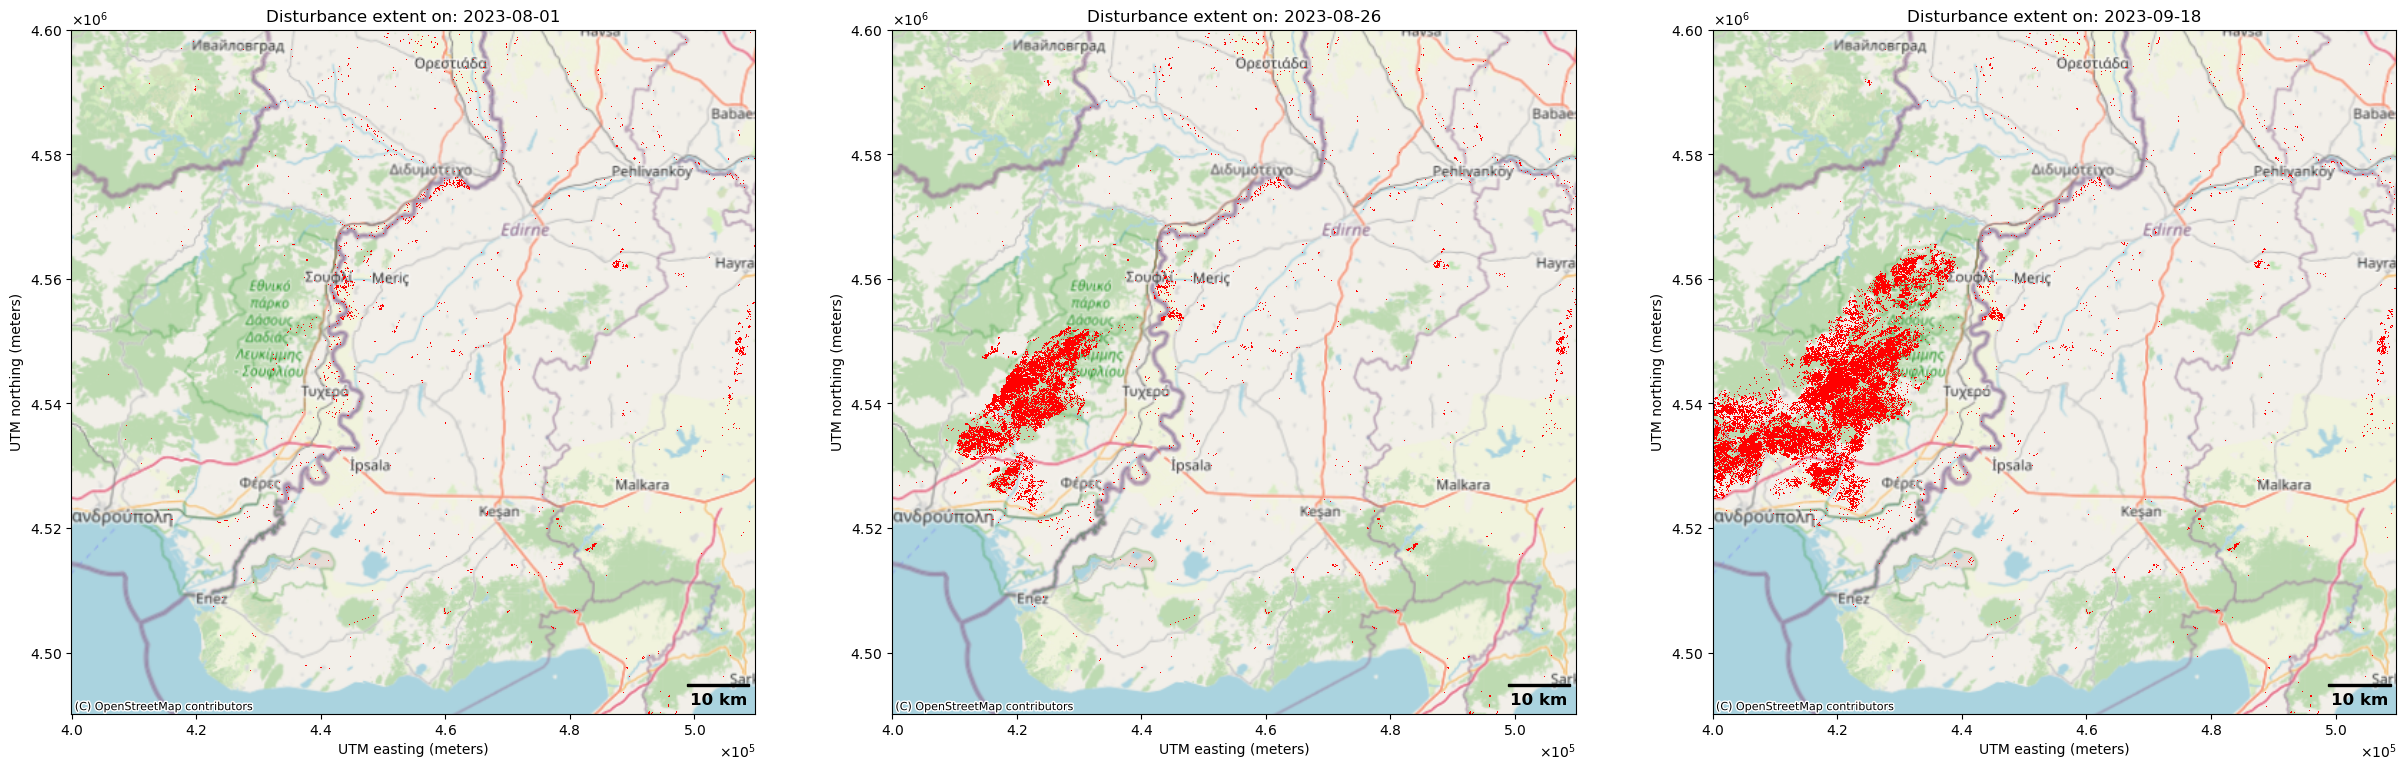

In [12]:
fig, ax = plt.subplots(1, 3, figsize = (30, 10))
crs = None

for i, (date, hrefs) in enumerate(zip(dates_of_interest, hrefs_of_interest)):
    
    # Read the crs to be used to generate basemaps
    if crs is None:
        with rasterio.open(hrefs[0]) as ds:
            crs = ds.crs

    if len(hrefs) == 1:
        with rasterio.open(hrefs[0]) as ds:
            raster = ds.read()
            transform = ds.transform
    else:
        raster, transform = merge(hrefs)

    show(raster, ax=ax[i], transform=transform, interpolation='none')
    cx.add_basemap(ax[i], crs=crs, zoom=9, source=cx.providers.OpenStreetMap.Mapnik)
    show(raster, ax=ax[i], transform=transform, interpolation='none', cmap=cmap)

    scalebar = AnchoredSizeBar(ax[i].transData,
                            10000 , '10 km', 'lower right', 
                            color='black',
                            frameon=False,
                            pad = 0.25,
                            sep=5,
                            fontproperties = {'weight':'semibold', 'size':12},
                            size_vertical=300)

    ax[i].add_artist(scalebar)
    ax[i].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
    ax[i].set_xlabel('UTM easting (meters)')
    ax[i].set_ylabel('UTM northing (meters)')
    ax[i].set_title(f"Disturbance extent on: {date.strftime('%Y-%m-%d')}")

Next, let's calculate the area extent of damage over time

In [13]:
damage_area = []
conversion_factor = (30*1e-3)**2 # to convert pixel count to area in km^2; each pixel is 30x30 meters

# this will take a few minutes to run, since we are retrieving data for multiple days
for index, row in refined_granules.iterrows():
    raster, transform = merge(row.hrefs)
    damage_area.append(np.sum(raster==6)*conversion_factor)

refined_granules['damage_area'] = damage_area


Text(0.5, 1.0, '2023 Dadia forest wildfire detected extent')

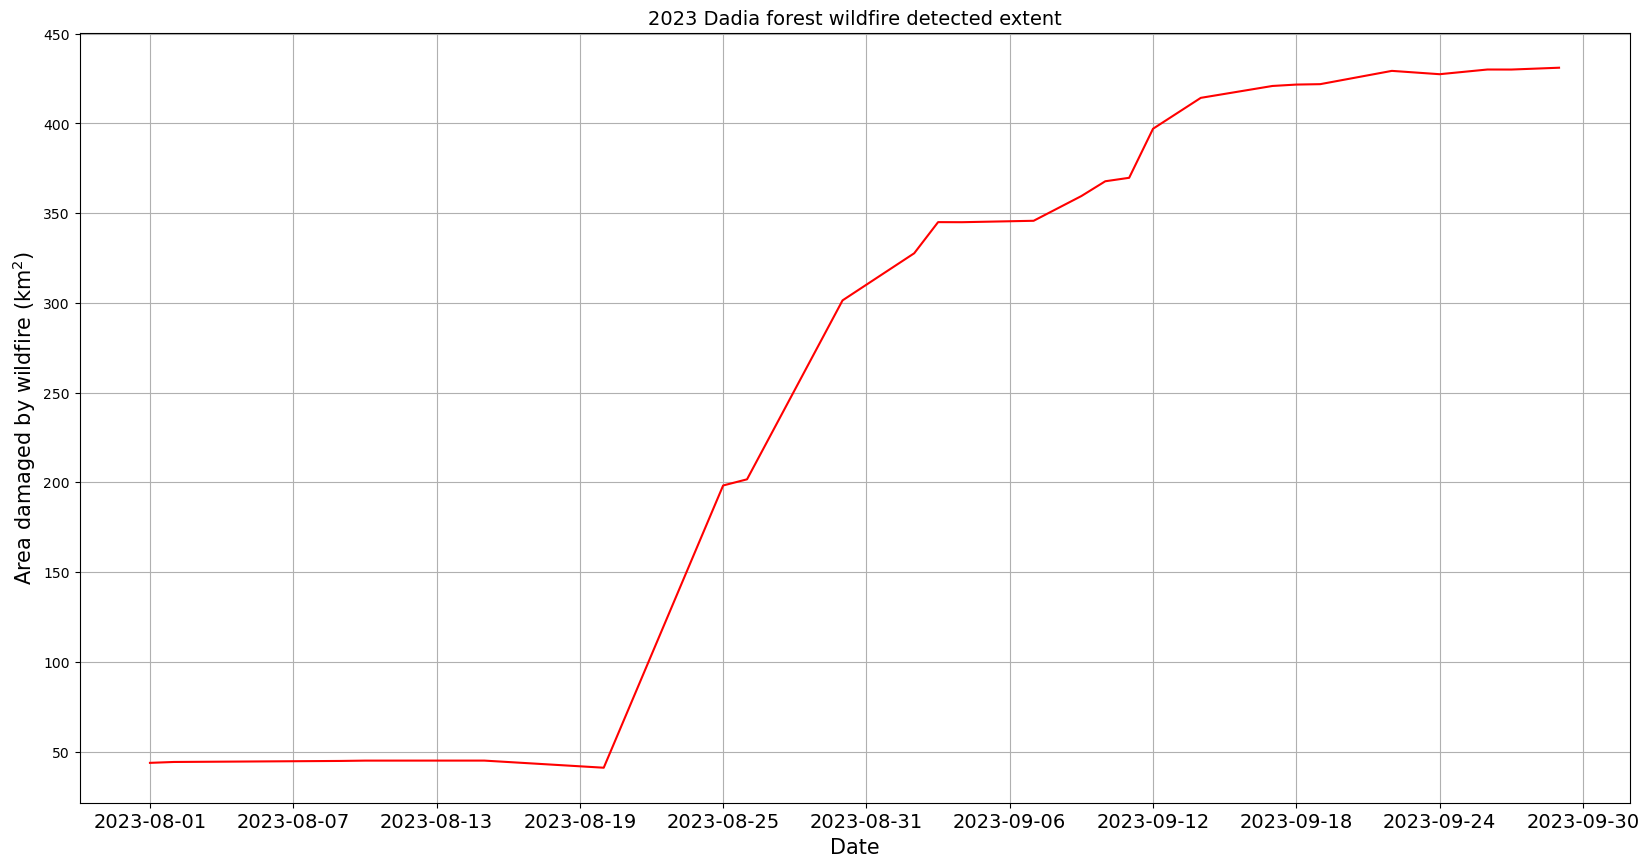

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot([datetime.strptime(i, '%Y-%m-%d') for i in refined_granules.index], refined_granules['damage_area'], color='red')
ax.grid()
plt.ylabel('Area damaged by wildfire (km$^2$)', size=15)
plt.xlabel('Date', size=15)
plt.xticks([datetime(year=2023, month=8, day=1) + timedelta(days=6*i) for i in range(11)], size=14)
plt.title('2023 Dadia forest wildfire detected extent', size=14)